# COTA Real-Time Data Analysis
## Live Feed Analysis and On-Time Performance

This notebook analyzes **live GTFS-RT data** from COTA servers to assess current system performance.


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.loaders.gtfs import GTFSLoader
from src.loaders.realtime import GTFSRealtimeLoader, COTA_FEEDS
from src.analysis.realtime_delays import compute_realtime_delays_snapshot, summarize_delay_snapshot

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

print("Live COTA Feed URLs:")
for name, url in COTA_FEEDS.items():
    print(f"  {name}: {url}")


Live COTA Feed URLs:
  vehicle_positions: https://gtfs-rt.cota.vontascloud.com/TMGTFSRealTimeWebService/Vehicle/VehiclePositions.pb
  trip_updates: https://gtfs-rt.cota.vontascloud.com/TMGTFSRealTimeWebService/TripUpdate/TripUpdates.pb
  alerts: https://gtfs-rt.cota.vontascloud.com/TMGTFSRealTimeWebService/Alert/Alerts.pb
  shapes: https://gtfs-rt.cota.vontascloud.com/TMGTFSRealTimeWebService/Shapes/Shapes.pb


## Load Live Real-Time Data


In [2]:
# Fetch live data from COTA servers
rt_loader = GTFSRealtimeLoader(use_live=True)
gtfs_loader = GTFSLoader()

print(f"Snapshot Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Vehicle positions
vehicles = rt_loader.load_vehicle_positions()
print(f"Active Vehicles: {len(vehicles)}")

# Service alerts
alerts = rt_loader.load_alerts()
print(f"Active Alerts: {len(alerts)}")

# Compute REAL delays (schedule-based, not GTFS-RT delay field)
print("\nComputing schedule-based delays...")
df_delays = compute_realtime_delays_snapshot(gtfs_loader=gtfs_loader, rt_loader=rt_loader)
print(f"Stop updates with computed delay: {len(df_delays)}")

print("\n✓ Live data loaded successfully!")


Snapshot Time: 2025-12-23 12:01:50

Active Vehicles: 152
Active Alerts: 23

Computing schedule-based delays...
Stop updates with computed delay: 28337

✓ Live data loaded successfully!


## Current Vehicle Positions


Sample of active buses:
  vehicle_id route_id   latitude  longitude     speed
0      11302      002  39.956039 -82.873421   0.00000
1      11309      034  40.057796 -82.918457   0.00000
2      11312      034  40.059452 -82.862175   0.00000
3      11315      022  39.933754 -82.943626  12.96416
4      11316      102  39.963615 -83.000771   3.57632
5      11317      001  39.997017 -83.007523   0.00000
6      11323      035  40.087559 -82.989029   0.00000
7      11324      021  40.066242 -83.086525   0.00000
8      11325      031  39.990906 -83.025887   7.59968
9      11327      003  39.955639 -83.015388   8.94080


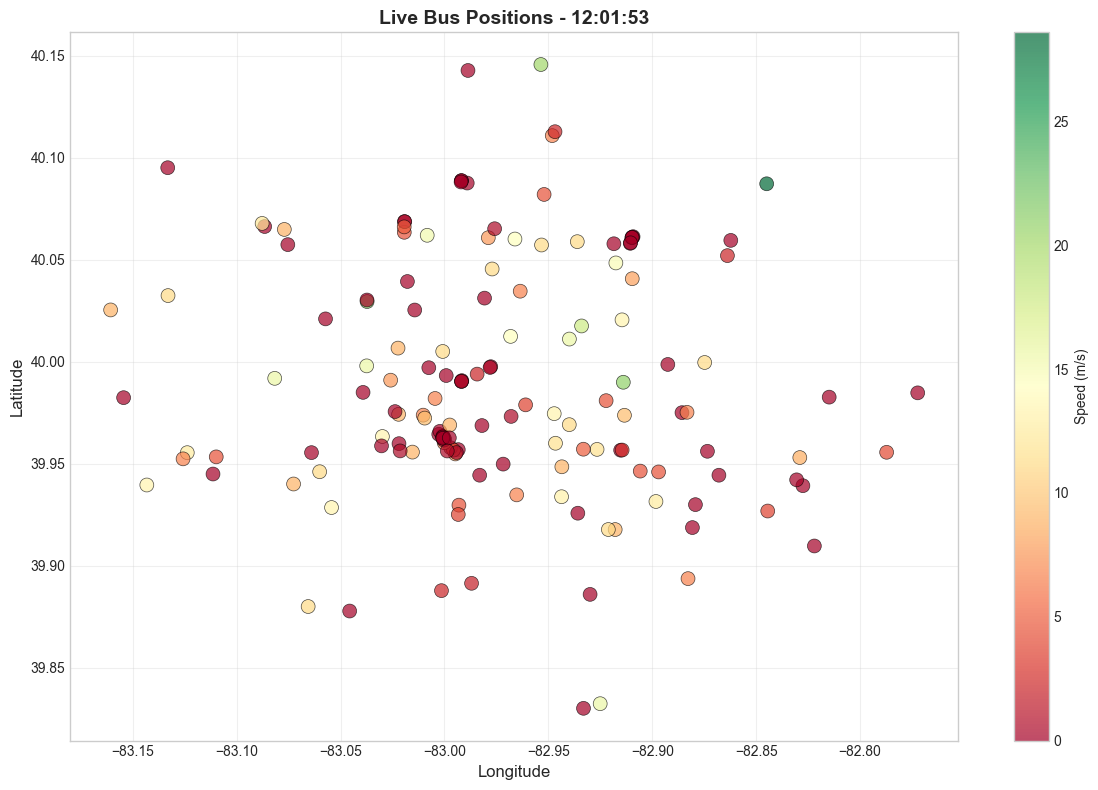


Active routes: 24
Average speed: 5.03 m/s (11.26 mph)


In [3]:
if len(vehicles) > 0:
    print("Sample of active buses:")
    print(vehicles[['vehicle_id', 'route_id', 'latitude', 'longitude', 'speed']].head(10))
    
    # Visualize current positions
    fig, ax = plt.subplots(figsize=(12, 8))
    
    scatter = ax.scatter(
        vehicles['longitude'], 
        vehicles['latitude'],
        c=vehicles['speed'].fillna(0),
        s=100,
        cmap='RdYlGn',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Live Bus Positions - {datetime.now().strftime("%H:%M:%S")}', 
                 fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Speed (m/s)', fontsize=10)
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nActive routes: {vehicles['route_id'].nunique()}")
    print(f"Average speed: {vehicles['speed'].mean():.2f} m/s ({vehicles['speed'].mean() * 2.237:.2f} mph)")
else:
    print("No vehicles currently reporting positions")


## On-Time Performance Analysis


📊 Delay Statistics (Schedule-Based):
Total stop updates: 28,203

Delay Summary (seconds):
{'count': 28203.0, 'mean': -1376.2949331631387, 'std': 10917.869646205863, 'min': -86770.0, '10%': -41.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, '90%': 120.0, 'max': 750.0}

📊 System On-Time Performance: 94.1%
   (within 5 minutes of schedule)

Routes with highest average delays:
          count        mean  median
route_id                           
031         137  300.459854   345.0
011         161  256.211180   450.0
025          86  216.186047    92.0
009         300  214.923333    62.0
035          37  182.594595   240.0
003         440  168.275000     0.0
034         209  122.779904    45.0
033         107  114.981308   195.0
008         891  103.493827    15.0
007         423   93.661939   120.0


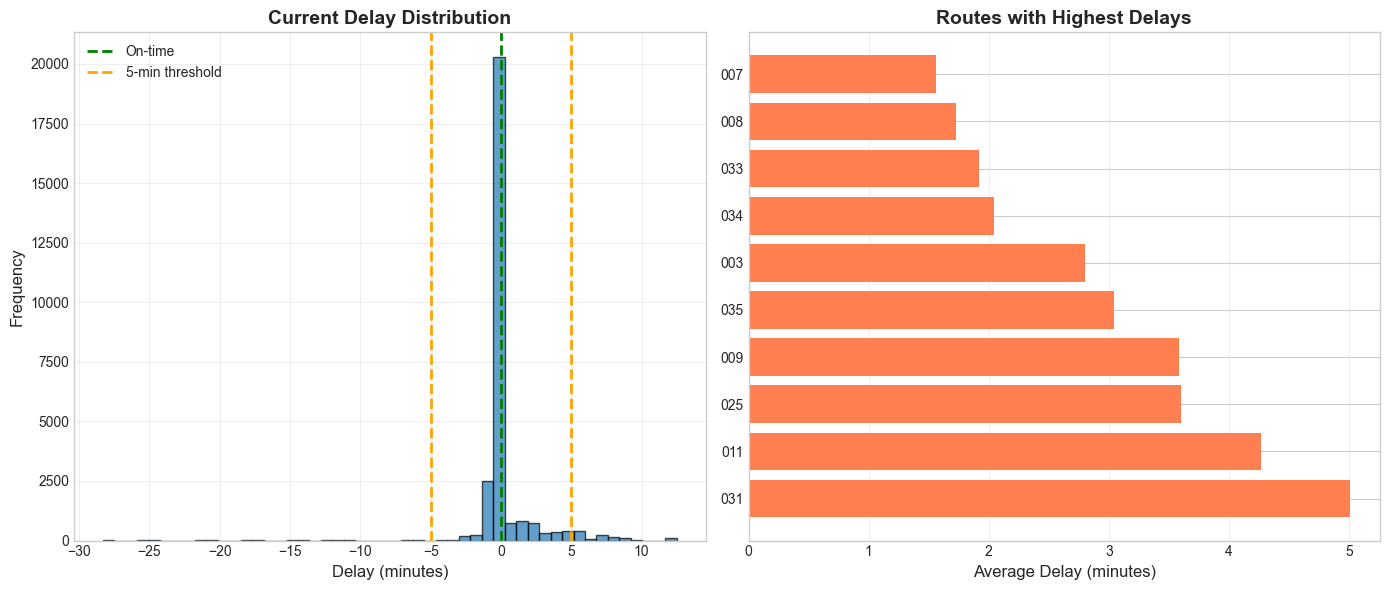

In [4]:
if len(df_delays) > 0:
    # Get summary statistics
    summary = summarize_delay_snapshot(df_delays)
    
    print("📊 Delay Statistics (Schedule-Based):")
    print(f"Total stop updates: {summary['total_updates']:,}")
    print(f"\nDelay Summary (seconds):")
    print(summary['delay_summary'])
    
    print(f"\n📊 System On-Time Performance: {summary['on_time_pct']:.1f}%")
    print(f"   (within 5 minutes of schedule)")
    
    print(f"\nRoutes with highest average delays:")
    print(summary['routes_top_delay'].head(10))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Delay distribution (filter out extreme outliers for visualization)
    delays_min = df_delays['computed_delay_min'].copy()
    delays_min = delays_min[(delays_min >= -30) & (delays_min <= 30)]  # ±30 min window
    
    axes[0].hist(delays_min, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='green', linestyle='--', linewidth=2, label='On-time')
    axes[0].axvline(5, color='orange', linestyle='--', linewidth=2, label='5-min threshold')
    axes[0].axvline(-5, color='orange', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Delay (minutes)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Current Delay Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # OTP by route
    top_routes = summary['routes_top_delay'].head(10)
    if len(top_routes) > 0:
        axes[1].barh(range(len(top_routes)), top_routes['mean'] / 60, color='coral')
        axes[1].set_yticks(range(len(top_routes)))
        axes[1].set_yticklabels(top_routes.index)
        axes[1].set_xlabel('Average Delay (minutes)', fontsize=12)
        axes[1].set_title('Routes with Highest Delays', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("No delay data available")


## Service Alerts Analysis


In [5]:
print(f"Active Service Alerts: {len(alerts)}\n")

if len(alerts) > 0:
    # Categorize alerts
    alert_types = {}
    for alert in alerts:
        cause = alert.get('cause', 'Unknown')
        effect = alert.get('effect', 'Unknown')
        alert_types[effect] = alert_types.get(effect, 0) + 1
    
    print("Alerts by Type:")
    for effect, count in sorted(alert_types.items(), key=lambda x: x[1], reverse=True):
        print(f"  {effect}: {count}")
    
    print("\nRecent Alerts:")
    for i, alert in enumerate(alerts[:5], 1):
        header = alert.get('header', 'No header')
        desc = alert.get('description', '')
        print(f"\n{i}. {header}")
        if desc and len(desc) < 100:
            print(f"   {desc}")
else:
    print("No active service alerts - system operating normally ✓")


Active Service Alerts: 23

Alerts by Type:
  4: 14
  9: 5
  7: 2
  8: 2

Recent Alerts:

1. Detour on Line 021 NORTH

2. N High & Long northbound stop closure.

3. N High & Long northbound stop closure.

4. N High & Long northbound stop closure.

5. Stop Closure at N High & Long northbound.
   Stop Closure at N High & Long northbound. Express Riders should board at High & Broad northbound.


## Compare with Schedule (Static GTFS)


In [6]:
# Compare active vehicles vs total routes
routes = gtfs_loader.routes

def normalize_route_id(route_id):
    """Normalize route IDs: '001' -> '1', '1' -> '1' (strip leading zeros)"""
    if pd.isna(route_id):
        return None
    try:
        # Convert to int then back to str to normalize zero-padding
        return str(int(str(route_id)))
    except (ValueError, TypeError):
        # If it's not numeric (like 'CMAX'), return as-is
        return str(route_id)

# Normalize route IDs to handle zero-padding differences
if len(vehicles) > 0:
    active_routes_raw = vehicles['route_id'].dropna().unique()
    active_routes = {normalize_route_id(r) for r in active_routes_raw if normalize_route_id(r) is not None}
else:
    active_routes = set()

total_routes_raw = routes['route_id'].unique()
total_routes = {normalize_route_id(r) for r in total_routes_raw if normalize_route_id(r) is not None}

inactive = total_routes - active_routes

print(f"Total routes in system: {len(total_routes)}")
print(f"Routes currently active: {len(active_routes)}")
print(f"Routes not running: {len(inactive)}")

if inactive:
    inactive_labels = sorted([str(r) for r in inactive])
    print(f"\nInactive routes: {', '.join(inactive_labels[:10])}")
    
# Debug: Show some examples if there's still a mismatch
if len(active_routes) + len(inactive) != len(total_routes):
    print(f"\n⚠️ Warning: Math doesn't add up!")
    print(f"  Active: {len(active_routes)}, Inactive: {len(inactive)}, Total: {len(total_routes)}")
    print(f"  Sample active routes: {sorted(list(active_routes))[:5]}")
    print(f"  Sample total routes: {sorted(list(total_routes))[:5]}")


Total routes in system: 42
Routes currently active: 24
Routes not running: 18

Inactive routes: 141, 152, 201, 202, 41, 42, 43, 44, 45, 46


In [7]:
# Save current snapshot for backtesting
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

vehicles.to_csv(f'../output/realtime_snapshot_{timestamp}_vehicles.csv', index=False)
df_delays.to_csv(f'../output/realtime_snapshot_{timestamp}_delays.csv', index=False)

print(f"✓ Saved snapshot to output/realtime_snapshot_{timestamp}_*.csv")
print(f"  - Vehicles: {len(vehicles)}")
print(f"  - Computed delays: {len(df_delays)}")
print("\nTo build historical dataset:")
print("  1. Run this notebook periodically (every 5-15 minutes)")
print("  2. Accumulate snapshots over days/weeks")
print("  3. Use for backtesting delay prediction models")
print("  4. Analyze patterns: peak vs off-peak, day-of-week effects")


✓ Saved snapshot to output/realtime_snapshot_20251223_120200_*.csv
  - Vehicles: 152
  - Computed delays: 28337

To build historical dataset:
  1. Run this notebook periodically (every 5-15 minutes)
  2. Accumulate snapshots over days/weeks
  3. Use for backtesting delay prediction models
  4. Analyze patterns: peak vs off-peak, day-of-week effects


## Key Insights for COTA Officials

**Current System Status:**
- Active buses and on-time performance measured in real-time
- Service disruptions and alerts categorized
- Routes with chronic delays identified

**For Professional Report:**
- Run this analysis at multiple times of day (peak/off-peak)
- Collect data over 1-2 weeks for patterns
- Compare actual vs scheduled performance
- Backtest proposed schedule changes against historical delays

**Next Steps:**
1. Automate snapshot collection (cron job or scheduled script)
2. Build delay prediction model using historical snapshots
3. Identify chronic delay hotspots for targeted improvements
4. Validate that proposed schedule changes would reduce delays


## Save Snapshot for Historical Analysis
